![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

## Regularization and Optimization for Neural Networks

---

_Authors: Matt Brems and Justin Pounders (but mainly Matt)_

The principal topic of the day is **how to control bias/variance tradeoff in neural nets.**

### Learning Objectives

By the end of the lesson, students should be able to:
- Explain how L1/L2, dropout, and early stopping regularization work and implement these methods in Keras
- Implement methods for speeding up learning
- Describe Gradient Descent with Momentum and Data Augmentation

In [93]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

import pandas as pd

%matplotlib inline

## Load the data

In [94]:
data = pd.read_csv('../data/cell_phone_churn.csv')
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [95]:
data = data.drop('state', axis=1)

# Many ways to binarize:
data['intl_plan'] = data['intl_plan'].map(lambda x: 1 if x=='yes' else 0)
data['vmail_plan'] = data['vmail_plan'].map(lambda x: 1 if x=='yes' else 0)

# data['intl_plan'] = data['intl_plan'].map({'yes': 1, 'no': 0})
# data['intl_plan'] = (data['intl_plan'] == 'yes').astype('int')
# data['intl_plan'] = (data['intl_plan'] == 'yes') * 1

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
account_length    3333 non-null int64
area_code         3333 non-null int64
intl_plan         3333 non-null int64
vmail_plan        3333 non-null int64
vmail_message     3333 non-null int64
day_mins          3333 non-null float64
day_calls         3333 non-null int64
day_charge        3333 non-null float64
eve_mins          3333 non-null float64
eve_calls         3333 non-null int64
eve_charge        3333 non-null float64
night_mins        3333 non-null float64
night_calls       3333 non-null int64
night_charge      3333 non-null float64
intl_mins         3333 non-null float64
intl_calls        3333 non-null int64
intl_charge       3333 non-null float64
custserv_calls    3333 non-null int64
churn             3333 non-null bool
dtypes: bool(1), float64(8), int64(10)
memory usage: 472.1 KB


In [96]:
X = data.drop('churn', axis=1)
y = data['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)



In [97]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [98]:
1 - y.mean()

0.8550855085508551

## Build a simple neural net to model churn

Let's build this:

- a dense network,
- one input layer,
- one hidden layer 
  - slightly smaller than input layer
  - ReLU activation
- single node output (for binary classification)
  - sigmoid activation
  
> **Fun fact**: If we dropped the hidden layer, this model would just be logistic regression!  Can you prove that to yourself?

In [99]:
n_input = X_train.shape[1]

In [100]:
n_input

18

In [101]:
#we are creating a 2 layer NN i.e 1 Hidden layer + 1output layer
model = Sequential()
#first hidden layer
model.add(Dense(18, input_dim=n_input, activation='relu'))
#output layer
model.add(Dense(1, activation='sigmoid'))

In [102]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [103]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=None,
    verbose=2
)

Train on 2499 samples, validate on 834 samples
Epoch 1/100
 - 0s - loss: 4.7091 - acc: 0.8167 - val_loss: 1.5052 - val_acc: 0.7974
Epoch 2/100
 - 0s - loss: 1.5589 - acc: 0.8075 - val_loss: 1.2168 - val_acc: 0.8129
Epoch 3/100
 - 0s - loss: 1.2478 - acc: 0.7967 - val_loss: 1.0029 - val_acc: 0.7818
Epoch 4/100
 - 0s - loss: 1.0254 - acc: 0.7927 - val_loss: 0.9972 - val_acc: 0.8669
Epoch 5/100
 - 0s - loss: 0.8939 - acc: 0.7947 - val_loss: 0.6764 - val_acc: 0.8237
Epoch 6/100
 - 0s - loss: 0.7472 - acc: 0.7999 - val_loss: 0.5706 - val_acc: 0.8465
Epoch 7/100
 - 0s - loss: 0.6061 - acc: 0.8211 - val_loss: 0.4920 - val_acc: 0.8537
Epoch 8/100
 - 0s - loss: 0.5143 - acc: 0.8271 - val_loss: 0.4857 - val_acc: 0.8573
Epoch 9/100
 - 0s - loss: 0.4709 - acc: 0.8483 - val_loss: 0.4018 - val_acc: 0.8657
Epoch 10/100
 - 0s - loss: 0.4330 - acc: 0.8403 - val_loss: 0.3848 - val_acc: 0.8621
Epoch 11/100
 - 0s - loss: 0.4048 - acc: 0.8507 - val_loss: 0.3728 - val_acc: 0.8621
Epoch 12/100
 - 0s - loss: 

Epoch 97/100
 - 0s - loss: 0.3792 - acc: 0.8539 - val_loss: 0.3504 - val_acc: 0.8597
Epoch 98/100
 - 0s - loss: 0.3571 - acc: 0.8611 - val_loss: 0.3902 - val_acc: 0.8309
Epoch 99/100
 - 0s - loss: 0.3652 - acc: 0.8555 - val_loss: 0.4514 - val_acc: 0.8513
Epoch 100/100
 - 0s - loss: 0.3567 - acc: 0.8567 - val_loss: 0.3384 - val_acc: 0.8609


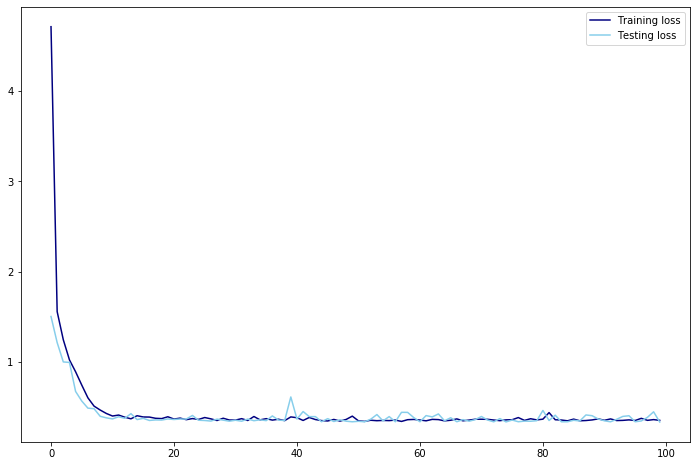

In [104]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [105]:
history.history['acc'][-1], history.history['val_acc'][-1]

(0.8567427, 0.8609112501144409)

Without regularization, **val_loss: 0.1820**.

![](../assets/overkill.jpg)

<a id='l1'></a>
## Regularization Method 1: L1 and L2 
---
Just as we did with linear and logistic regression, we can use `L1` and `L2` regularization on our neural networks.

Neural networks are just large combinations of linear functions that are modified using some activation function:

$$z = b_0 + \sum_{j=1}^p w_j x_j$$
$$a = g(z)$$

Where $x_j$ is one input (i.e. one observation's blood pressure, one observation's sex, etc.), $w_j$ is the weight/coefficient for that particular variable, $b_0$ is our bias, and $g$ is our activation function. If we used a sigmoid function as we would for logistic regression, $g$ would be:
$$g(z) = \frac{1}{1 + e^{-z}}$$

After we've done this for every node, we can then compute the loss for every node as a function of their parameters:
$$\text{loss} = \frac{1}{m}\sum_{i=1}^{m}L(\hat{y}_i, y_i)$$

This is our average loss. In a regression context, this is usually mean squared error; in a classification context this might be categorical cross-entropy or something else. This would be our loss function *without regularization*.

We'll then implement gradient descent:

$$w_j := w_j -\alpha\frac{\partial \text{loss}}{\partial w_j}$$

where $\alpha$ is our learning rate and $\frac{\partial \text{loss}}{\partial w_j}$ represents the partial derivative of our loss function with respect to our weight $w_j$.

This is how we implement gradient descent **without regularization**.

#### So, how do we implement gradient descent with `L1` or `L2` regularization?

> We just change the loss function to add a penalty! If we want to add a penalty term, we do the **exact same thing** we did with linear or logistic regression:

$$\text{L2 regularized loss} = \frac{1}{m}\sum_{i=1}^{m}L(\hat{y}_i, y_i) + \frac{\lambda}{2m}\sum_{l=1}^{L}||w_{[l]}||^2$$

Now, $$\frac{\partial \text{L2 regularized loss}}{\partial w_{[l]}} = \frac{\partial \text{loss}}{\partial w_j} + \frac{\lambda}{m}w_j$$
and
$$w_j := w_j -\alpha\frac{\partial \text{L2 regularized loss}}{\partial w_j}$$

In this example we used `L2` regularization, although `L1` works in the same way. You may see `L2` regularization referred to as "*weight decay*."

**Practical Note:** According to Andrew Ng, `L2` (as opposed to `L1`) is generally used for regularizing neural networks and it's rare to find `L1`.

As before, $\lambda$ is a hyperparameter to be selected by constructing multiple networks and identifying which value performs the best.
- Intuitively, as $\lambda \rightarrow \infty$, our weights get closer and closer to 0 (just like when we regularized our linear models before).
- Intuitively, as $\lambda \rightarrow \infty$, if we're using the `sigmoid` or `tanh` activation functions, we force our weights to stay in that "linear" region in the middle. This speeds up the learning process!

In [106]:
from keras import regularizers

model_l2 = Sequential()

n_input = X_train.shape[1]

model_l2.add(Dense(
    18,
    input_dim=n_input,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)
))
model_l2.add(Dense(
    1,
    activation='sigmoid',
    kernel_regularizer=regularizers.l2(0.01)
))

model_l2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

history_l2 = model_l2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=None
)

Train on 2499 samples, validate on 834 samples
Epoch 1/100
2499/2499 [==============================] - 0s 86us/step - loss: 3.5037 - acc: 0.7755 - val_loss: 2.0084 - val_acc: 0.7290
Epoch 2/100
2499/2499 [==============================] - 0s 33us/step - loss: 1.5369 - acc: 0.7567 - val_loss: 1.1414 - val_acc: 0.7494
Epoch 3/100
2499/2499 [==============================] - 0s 30us/step - loss: 1.0313 - acc: 0.7859 - val_loss: 0.9034 - val_acc: 0.8309
Epoch 4/100
2499/2499 [==============================] - 0s 28us/step - loss: 0.8209 - acc: 0.8151 - val_loss: 0.7469 - val_acc: 0.8381
Epoch 5/100
2499/2499 [==============================] - 0s 28us/step - loss: 0.7356 - acc: 0.8219 - val_loss: 0.6627 - val_acc: 0.8417
Epoch 6/100
2499/2499 [==============================] - 0s 29us/step - loss: 0.6486 - acc: 0.8399 - val_loss: 0.6160 - val_acc: 0.8513
Epoch 7/100
2499/2499 [==============================] - 0s 29us/step - loss: 0.5750 - acc: 0.8447 - val_loss: 0.6316 - val_acc: 0.8537
E

2499/2499 [==============================] - 0s 29us/step - loss: 0.4327 - acc: 0.8747 - val_loss: 0.3599 - val_acc: 0.8921
Epoch 61/100
2499/2499 [==============================] - 0s 25us/step - loss: 0.4149 - acc: 0.8776 - val_loss: 0.3659 - val_acc: 0.8885
Epoch 62/100
2499/2499 [==============================] - 0s 26us/step - loss: 0.3807 - acc: 0.8852 - val_loss: 0.3654 - val_acc: 0.8885
Epoch 63/100
2499/2499 [==============================] - 0s 25us/step - loss: 0.3784 - acc: 0.8860 - val_loss: 0.3592 - val_acc: 0.8909
Epoch 64/100
2499/2499 [==============================] - 0s 26us/step - loss: 0.3770 - acc: 0.8848 - val_loss: 0.3634 - val_acc: 0.8909
Epoch 65/100
2499/2499 [==============================] - 0s 26us/step - loss: 0.3719 - acc: 0.8848 - val_loss: 0.3634 - val_acc: 0.8849
Epoch 66/100
2499/2499 [==============================] - 0s 26us/step - loss: 0.3809 - acc: 0.8816 - val_loss: 0.3618 - val_acc: 0.8909
Epoch 67/100
2499/2499 [==============================

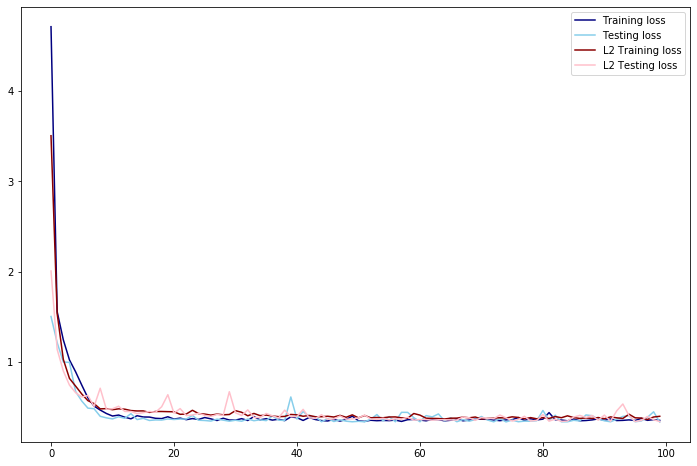

In [107]:
train_loss_l2 = history_l2.history['loss']
test_loss_l2 = history_l2.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

With `L2` regularization and $\lambda = 0.01$, **val_loss: 0.2075**.

In [108]:
history_l2.history['acc'][-1], history_l2.history['val_acc'][-1]

(0.877551, 0.8968824744224548)

## Keras Resources
- [Keras Regularization Documentation](https://keras.io/regularizers/)
- [Kernel vs. Activity Regularizers](https://github.com/keras-team/keras/issues/3236)

## Tensorflow Resources
- [Implementation in Tensorflow](https://www.tensorflow.org/versions/r0.12/api_docs/python/contrib.layers/regularizers)
- [Example in Tensorflow](http://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/)

<a id='dropout'></a>
## Regularization Method 2: Dropout
---
There's another method of regularizing our terms that is specifically designed for neural networks, called **dropout regularization.**

Let's say we've constructed a neural network. We've decided on the number of layers we want and the number of nodes in each layer. (We might say that we've decided on the **topology** or **structure** of our network.)

![](../assets/original_nn.jpeg)

However, a densely connected network like this will almost certainly overfit. Our network is learning a parameter for every single connection.

> We can overcome this by using **dropout regularization**. 

In dropout regularization, we randomly **drop** units (nodes) in our neural network ***during our training phase only***. We assign a probability of each node disappearing. Then, we essentially perform a coinflip for every node to turn that node "on" or "off."

Let's go through an example to illustrate this: For simplicity, we'll say we've assigned a 0.5 probability of keeping to every node in the network above. Then, for every node, we flip a coin, and if the coin lands on heads, the node remains, if it lands on tails, the node disappears. After we've done this for every node, we're left with a new network that looks something like this:

![](../assets/after_dropout.jpeg)

<!--
Image sources: https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/
Also, it seems, this site: http://cs231n.github.io/neural-networks-2/
-->

Let's explicitly lay out the general workflow you would follow:

1. Specify the **topology** of your neural network.
2. Initialize your weights and biases.
3. Specify the "keeping probabilities" for every node. (Generally, we'll assign the same probability to all nodes in each layer and usually the same probability to all hidden layers.)
4. Perform a "coin flip" for each node and drop out the chosen nodes.
5. Run through one epoch of training.
6. Repeat steps 4 and 5 for each epoch of training.

**Check:** If I drop out a node during one of my epochs, does it disappear from my final network?

#### So, what does this do?
<!-- <br/> -->
The intuition behind dropout is that, since each node has a probability of disappearing at any time, the neural network is disincentivized from allocating too much power to any one weight. It has a similar effect as imposing an L2 penalty: the magnitude of our weights shrinks.

**Check:** What might be some potential problems with doing this?

<!--
expected values of nodes changes; induces bias
-->

#### Inverted Dropout

In order to avoid any issues with the expected values of our nodes changing, we adjust our results accordingly by a method called **inverted dropout**.

If we have a hidden layer with 100 nodes and each node has a 80% probability of being "staying turned on," we only have 80% of those inputs to our node. As a result, we expect that the combined input to our node $z = b_0 + \sum_{i=1}^pw_ix_i$ will be off by about 20%. (Those interested in probability and research might note that the Binomial distribution is a very convenient model for neural networks and dropout.)

When using inverted dropout, we adjust $z$ by the "keeping probability."

$$
\begin{eqnarray*}
z_{original} &=& b_0 + \sum_{i=1}^pw_ix_i \\
\Rightarrow z_{dropout} &=& b_0 + \sum_{i\in\{included\_nodes\}}w_ix_i \\
\Rightarrow z_{inverted\_dropout} &:=& z_{dropout} / 0.8 \\
\end{eqnarray*}
$$

#### Test time:

So we've now run through every epoch of our training phase and we're ready to apply our neural network to our validation or testing data. Are we going to apply dropout to this data as well?

**NO.**

#### Best practices:

- Don't set any keeping probabilities for layers you where you don't want to drop any nodes. (What might be examples of these layers?)
<!--
Input and output layers
-->
- You'll generally want to specify a single keeping probability and all the layers on which you want to apply dropout, instead of specifying different keeping probabilities for each layer.

In [109]:
from keras.layers import Dropout

model_dropout = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input

model_dropout.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model_dropout.add(Dropout(0.5)) # refers to nodes in the first hidden layer
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history_dropout = model_dropout.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test), 
    epochs=100,
    batch_size=None
)

Train on 2499 samples, validate on 834 samples
Epoch 1/100
2499/2499 [==============================] - 0s 89us/step - loss: 10.7814 - acc: 0.7231 - val_loss: 3.6813 - val_acc: 0.8501
Epoch 2/100
2499/2499 [==============================] - 0s 32us/step - loss: 2.9461 - acc: 0.7331 - val_loss: 1.2574 - val_acc: 0.8453
Epoch 3/100
2499/2499 [==============================] - 0s 30us/step - loss: 0.9894 - acc: 0.8311 - val_loss: 0.6897 - val_acc: 0.8501
Epoch 4/100
2499/2499 [==============================] - 0s 31us/step - loss: 0.6212 - acc: 0.8543 - val_loss: 0.5707 - val_acc: 0.8477
Epoch 5/100
2499/2499 [==============================] - 0s 31us/step - loss: 0.5705 - acc: 0.8547 - val_loss: 0.5260 - val_acc: 0.8489
Epoch 6/100
2499/2499 [==============================] - 0s 29us/step - loss: 0.5289 - acc: 0.8555 - val_loss: 0.5213 - val_acc: 0.8489
Epoch 7/100
2499/2499 [==============================] - 0s 31us/step - loss: 0.5443 - acc: 0.8563 - val_loss: 0.4899 - val_acc: 0.8501


2499/2499 [==============================] - 0s 28us/step - loss: 0.4085 - acc: 0.8567 - val_loss: 0.4255 - val_acc: 0.8489
Epoch 61/100
2499/2499 [==============================] - 0s 27us/step - loss: 0.4101 - acc: 0.8567 - val_loss: 0.4268 - val_acc: 0.8489
Epoch 62/100
2499/2499 [==============================] - 0s 28us/step - loss: 0.4094 - acc: 0.8567 - val_loss: 0.4262 - val_acc: 0.8489
Epoch 63/100
2499/2499 [==============================] - 0s 27us/step - loss: 0.4084 - acc: 0.8567 - val_loss: 0.4242 - val_acc: 0.8489
Epoch 64/100
2499/2499 [==============================] - 0s 28us/step - loss: 0.4087 - acc: 0.8567 - val_loss: 0.4307 - val_acc: 0.8489
Epoch 65/100
2499/2499 [==============================] - 0s 27us/step - loss: 0.4053 - acc: 0.8567 - val_loss: 0.4228 - val_acc: 0.8501
Epoch 66/100
2499/2499 [==============================] - 0s 27us/step - loss: 0.4086 - acc: 0.8567 - val_loss: 0.4254 - val_acc: 0.8489
Epoch 67/100
2499/2499 [==============================

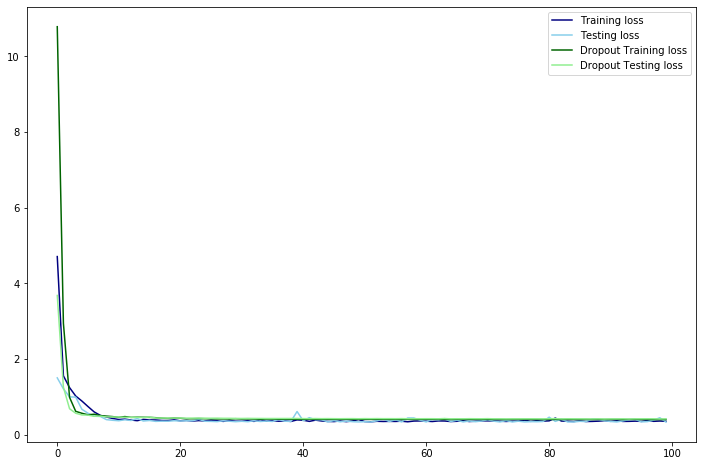

In [110]:
train_loss_dropout = history_dropout.history['loss']
test_loss_dropout = history_dropout.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')
plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')
plt.legend();

With Dropout, **val_loss: 0.1612**.

In [111]:
history_dropout.history['acc'][-1], history_dropout.history['val_acc'][-1]

(0.8567427, 0.8501198887825012)

## Keras Resources
- [Keras Dropout Documentation](https://keras.io/layers/core/#dropout)

## Tensorflow Resources
- [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [List of examples in Tensorflow](https://programtalk.com/python-examples/tensorflow.nn.dropout/)

<a id='stopping'></a>
## Regularization Method 3: Early Stopping
---
The third method of regularization that we'll discuss today is called early stopping.
</br>
If we run though all our epochs of training and plot both our training and validation error, we'll typically see something like this:

![](../assets/train-val-error-reduced.png)
*source: [Prechelt, 1997](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf) *

**Check:** What is happening in this plot?

Early stopping does exactly what its name implies: it stop the training process early. Instead of continuing training through every epoch, once the validation error begins to increase, our algorithm stops because it has (in theory) found the minimum for the validation loss.

This might seem like a simple and robust solution to overfitting, but it can run into problems.

![](../assets/validation-error-real.png)

There is debate over how often this problem occurs. You can generally plot both the training and validation loss, see if you're getting multiple optima. If you are, there are multiple suggested techniques to combat this problem in the [paper reference above](http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf).

In [112]:
from keras.callbacks import EarlyStopping

model_es = Sequential()

n_input = X_train.shape[1]

model_es.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

history_es = model_es.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=None,
    callbacks=[early_stop]
)

Train on 2499 samples, validate on 834 samples
Epoch 1/100
2499/2499 [==============================] - 0s 75us/step - loss: 21.7586 - acc: 0.5550 - val_loss: 5.5171 - val_acc: 0.7638
Epoch 2/100
2499/2499 [==============================] - 0s 33us/step - loss: 4.1788 - acc: 0.7411 - val_loss: 3.3071 - val_acc: 0.7758
Epoch 3/100
2499/2499 [==============================] - 0s 29us/step - loss: 3.1546 - acc: 0.7647 - val_loss: 2.5306 - val_acc: 0.7806
Epoch 4/100
2499/2499 [==============================] - 0s 29us/step - loss: 2.4892 - acc: 0.7803 - val_loss: 1.9697 - val_acc: 0.7878
Epoch 5/100
2499/2499 [==============================] - 0s 29us/step - loss: 1.9796 - acc: 0.7927 - val_loss: 1.6195 - val_acc: 0.8273
Epoch 6/100
2499/2499 [==============================] - 0s 29us/step - loss: 1.5534 - acc: 0.7967 - val_loss: 1.2562 - val_acc: 0.8225
Epoch 7/100
2499/2499 [==============================] - 0s 29us/step - loss: 1.2213 - acc: 0.8019 - val_loss: 1.0465 - val_acc: 0.8393


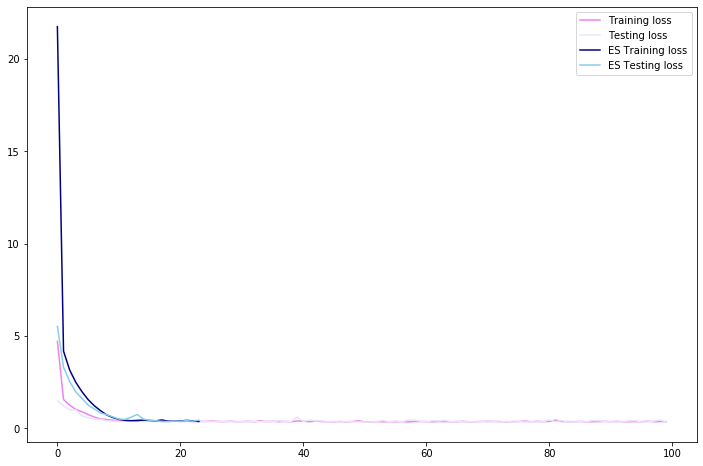

In [113]:
train_loss_es = history_es.history['loss']
test_loss_es = history_es.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='violet')
plt.plot(test_loss, label='Testing loss', color='lavender')
plt.plot(train_loss_es, label='ES Training loss', color='navy')
plt.plot(test_loss_es, label='ES Testing loss', color='skyblue')
plt.legend();

With early stopping, **val_loss: 0.1210**.

In [114]:
history_es.history['acc'][-1], history_es.history['val_acc'][-1]

(0.8607443, 0.8513189554214478)

## Keras Resources
- [Keras EarlyStopping Documentation](https://keras.io/callbacks/#earlystopping)
- [Keras EarlyStopping Example](http://parneetk.github.io/blog/neural-networks-in-keras/)

## Tensorflow Resources
- [Tensorflow.Keras.callbacks.EarlyStopping Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

# Optimization
---
Now we're going to talk about ways to speed up the process of optimization. Surprisingly, local optima are not often problems with neural networks; there's a much larger issue with "plateaus," or areas where the derivative is approximately 0. This makes learning much slower.

## Quick Fixes:
1. **Feature Scaling:** As we've discussed before, feature scaling can speed up the process of gradient descent. Because gradient descent works "geometrically," the scales of our $w$ values have a large impact on how quickly our parameters converge to the true value. Since we're working with many parameters (often 1,000 or more), scaling our features will speed up optimization.

2. **Mini-batch Gradient Descent:** In `sklearn`, we use `.fit()` to estimate the parameters in our model. We do the same in neural networks, but if we're working with a very large data set (as is common in neural networks), passing data through our network will cause learning to be slow. By specifying a `batch_size` within the `.fit()` method, we can expedite our learning.
    - `batch_size`: Integer or `None`. Number of samples per gradient update. If unspecified, it will default to 32.
    
**Note:** Mini batches will usually be a power of 2 (32, 64, 128, 256, 512) due to the fact that computers operate in base 2.

- [Overview of the three types of gradient descent: batch, stochastic, mini-batch](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)

<a id='momentum'></a>
## Gradient Descent with Momentum

One problem we notice with mini-batch gradient descent compared to batch gradient descent is that it tends to oscillate more, due to the fact that at each iteration it is being fed less training data than batch gradient descent.

![](./assets/grad-descent.png)
![](./assets/mini-grad-descent.png)

*[source](http://pengcheng.tech/2017/09/28/gradient-descent-momentum-and-adam/)*

Ideally, we'd like to take advantage of the speed and memory efficiency of mini-batch gradient descent, without the oscillations. We can use the idea of **momentum** to help us out here. (Momentum is based on [exponentially weighted moving averages](https://www.compose.com/articles/metrics-maven-calculating-an-exponentially-weighted-moving-average-in-postgresql/), which causes our oscillations to largely cancel each other out.) 

Typically, when updating our parameters, we'll follow this formula:

$$W = W -\alpha\frac{\partial \text{loss}}{\partial W}$$  
$$b = b - \alpha\frac{\partial \text{loss}}{\partial b}$$

We're going to modify this formula to this form:

$$W = W -\alpha V_{\partial W}$$  
$$b = b - \alpha V_{\partial b}$$

Where 
$$V_{\partial W} = \beta V_{\partial W - 1} + (1-\beta)\frac{\partial \text{loss}}{\partial W}$$
and
$$V_{\partial b} = \beta V_{\partial b - 1} + (1-\beta)\frac{\partial \text{loss}}{\partial b}$$

When implementing gradient descent with momentum, you'll have two hyperparameters, $\alpha$ and $\beta$. From a practical point of view, $\beta$ is typically $0.9$, but you can test out other values if you'd like.

### ADAM Optimization

The optimization algorithm you'll likely use when implementing your feed-forward neural network is called ADAM (Adaptive Moment Estimation). It is a combination of gradient descent with momentum and another optimization method called RMSProp (Root Mean Square Propagation). For the sake of this lesson, we won't cover how ADAM works, but with gradient descent with momentum as building block, the ADAM optimization is not too far off, as it largely relies on the concept of momentum.

### Data Augmentation

One method of minimizing the risk of overfitting is to gather more data. While this is usually very costly, we may sometimes be able to take our existing data to generate substantially more data.
- Images: Reflect, crop, random rotations or distortions, adjust lighting.
    - [The Effectiveness of Data Augmentation in Image Classification using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
- Non-Images: SMOTE (Synthetic Minority Over-Sampling Technique)
    - [SMOTE Paper](http://www.jair.org/media/953/live-953-2037-jair.pdf)

<a id='conclusion'></a>
# Conclusion

Today, we learned about three different methods of regularizing our neural networks: Regularization, dropout, and early stopping.

## Machine Learning Workflow

As promised, managing bias and variance takes a lot of our attention. If our bias or variance are high, it's likely that our model isn't performing as well as it could.

A workflow for how you should address this (in the context of neural networks and beyond) is as follows:

- Do we have high bias? (i.e. are we performing poorly on our training set?)
    - If so:
        - let's build a more complex model / bigger network!
        - let's consider a new architecture for our neural network!
        - let's train longer!
- Do we have high variance? (i.e. are we performing poorly on our test/holdout set?)
    - If so:
        - let's gather more data!
            - Usually very difficult, but we should use "data augmentation" if we can!
        - let's build a simpler model / smaller network!
        - let's consider a new architecture for our neural network!
        - let's regularize!
    - Once we're satisfied, return to the bias question and repeat.
    
**Note:** Before deep learning, most tools for handling high bias or high variance adversely affected the other. However, depending on the amount of data we have and how complex our network is, it's often the case that we can drastically reduce variance with out affecting bias.

We also learned about Mini-batch Gradient Descent and Gradient Descent with Momentum. You will almost always work with mini batches. And when optimizing, you will generally use a method called Adam Optimization that is built on a combination of Gradient Descent with Momentum and another optimization technique called RMSProp.

We also briefly discussed data augmentation as a method for increasing our sample sie.

<a id='references'></a>
## References and Resources:

- [DeepLearning.ai](https://www.deeplearning.ai/), Andrew Ng's Coursera course on Deep Learning
  - The videos from this course are on a [YouTube Channel](https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w/featured)   
<br>
- [Deep Learning Book](http://www.deeplearningbook.org/), textbook written by Ian Goodfellow, creator of Generative Adversarial Networks (GANs)